In [3]:
import pandas as pd

# Load the dataset
file_path = '/Users/sorinslavescu/work/health/basedata.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

,Sex,age,ADP,ASPI,Asp,Clop,thrombosis
0,F,72.0,137,32,Y,Y,Y
1,M,51.0,60,48,Y,Y,N
2,M,61.0,63,41,Y,N,Y
3,F,66.0,60,18,Y,Y,N
4,M,68.0,27,27,Y,Y,N


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Handle missing values for 'age'
data['age'].fillna(data['age'].median(), inplace=True)

# Encode categorical variables
data['Sex'] = data['Sex'].map({'F': 0, 'M': 1})
data['Asp'] = data['Asp'].map({'N': 0, 'Y': 1})
data['Clop'] = data['Clop'].map({'N': 0, 'Y': 1})
data['thrombosis'] = data['thrombosis'].map({'N': 0, 'Y': 1})

# Adding new features
data['ASP_resist'] = ((data['ADP'] > 32) & (data['Asp'] == 1)).astype(int)
data['Clop_resist'] = ((data['ASPI'] > 42) & (data['Clop'] == 1)).astype(int)

# Adjusting the approach for resistance features
data['Resist_Either'] = (((data['ASP_resist'] == 1) & (data['Clop_resist'] == 0)) | ((data['ASP_resist'] == 0) & (data['Clop_resist'] == 1))).astype(int)
data['Resist_Both'] = ((data['ASP_resist'] == 1) & (data['Clop_resist'] == 1)).astype(int)
data['Resist_Neither'] = ((data['ASP_resist'] == 0) & (data['Clop_resist'] == 0)).astype(int)


In [10]:
data.describe

<bound method NDFrame.describe of      Sex   age  ADP  ASPI  Asp  Clop  thrombosis  ASP_resist  Clop_resist  \
0      0  72.0  137    32    1     1           1           1            0   
1      1  51.0   60    48    1     1           0           1            1   
2      1  61.0   63    41    1     0           1           1            0   
3      0  66.0   60    18    1     1           0           1            0   
4      1  68.0   27    27    1     1           0           0            0   
..   ...   ...  ...   ...  ...   ...         ...         ...          ...   
158    1  76.0   66    28    1     1           1           1            0   
159    1  74.0   26    17    1     1           0           0            0   
160    1  61.0   42    40    1     1           0           1            0   
161    1  78.0   84    66    1     1           1           1            1   
162    1  74.0   21    17    1     1           0           0            0   

     Resist_Either  Resist_Both  Resist_N

In [5]:
import statsmodels.api as sm

# Prepare data for logistic regression analysis
X = data[['Resist_Either', 'Resist_Both', 'Resist_Neither', 'age', 'Sex']]
y = data['thrombosis']

# Add a constant to the features
X_with_const = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X_with_const)
result = logit_model.fit()

# Display the summary
result.summary()


Optimization terminated successfully.
         Current function value: 0.495864
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             thrombosis   No. Observations:                  163
Model:                          Logit   Df Residuals:                      158
Method:                           MLE   Df Model:                            4
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                 0.08686
Time:                        21:07:33   Log-Likelihood:                -80.826
converged:                       True   LL-Null:                       -88.514
Covariance Type:            nonrobust   LLR p-value:                  0.003982
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.0594   1.29e+07  -3.15e-07      1.000   -2.53e+07    2.53e+07
Resist_Either     -1.7445   1.29e+07  -1.35e-07      1.000   -2.53e+07    2.53e+07
Resist_Both       -0.7631   1.29e+07  -5.91e-08      1.000   -2.53e+07    2.53e+07
Resist_Neither    -1.5518   1.29e+07   -1.2e-07      1.000   -2.53e+07    2.53e+07
age                0.0624      0.019      3.217      0.001       0.024       0.100
Sex               -0.2752      0.440     -0.626      0.531      -1.137       0.587
==================================================================================
"""

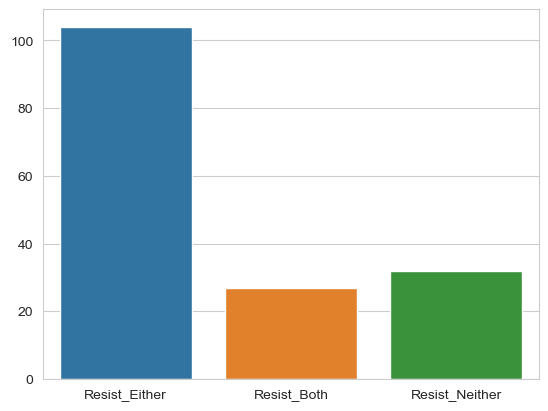

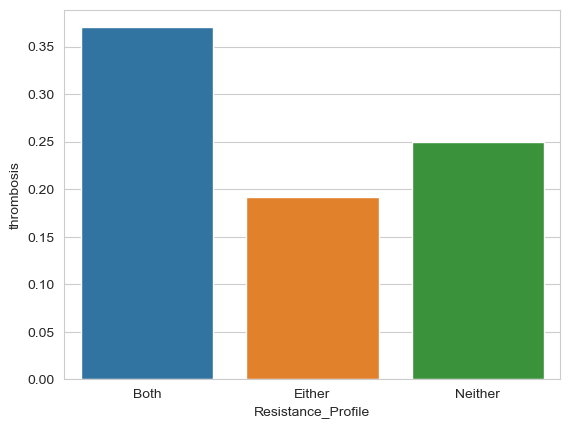

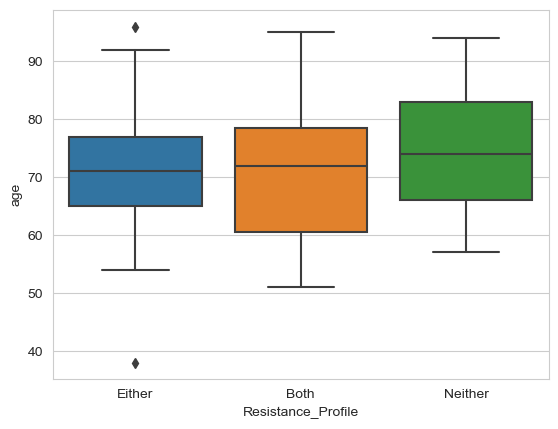

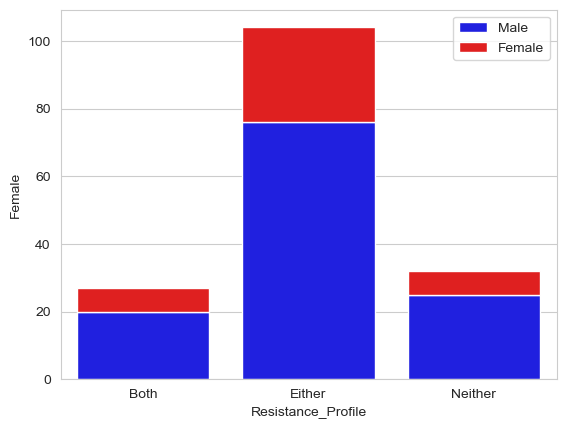

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Distribution of Resistance Features
resistance_counts = data[['Resist_Either', 'Resist_Both', 'Resist_Neither']].sum()
sns.barplot(x=resistance_counts.index, y=resistance_counts.values)
plt.show()

# Thrombosis Rates by Resistance Profile
temp_data = data.copy()
temp_data['Resistance_Profile'] = temp_data.apply(lambda x: 'Either' if x['Resist_Either'] == 1 else ('Both' if x['Resist_Both'] == 1 else 'Neither'), axis=1)
thrombosis_rates = temp_data.groupby('Resistance_Profile')['thrombosis'].mean().reset_index()
sns.barplot(x='Resistance_Profile', y='thrombosis', data=thrombosis_rates)
plt.show()

# Age Distribution by Resistance Profile
sns.boxplot(x='Resistance_Profile', y='age', data=temp_data)
plt.show()

# Gender Distribution by Resistance Profile
temp_data['Sex'] = temp_data['Sex'].map({0: 'Female', 1: 'Male'})
gender_distribution = temp_data.groupby(['Resistance_Profile', 'Sex']).size().unstack().reset_index()
sns.barplot(x='Resistance_Profile', y='Male', data=gender_distribution, color='blue', label='Male')
sns.barplot(x='Resistance_Profile', y='Female', data=gender_distribution, color='red', bottom=gender_distribution['Male'], label='Female')
plt.legend()
plt.show()


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


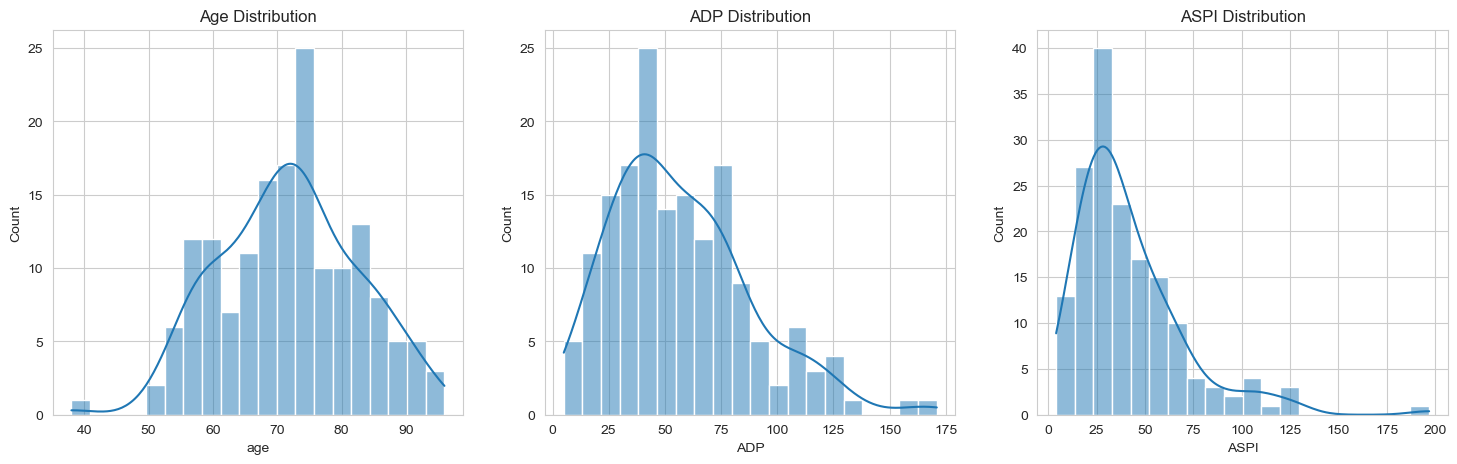

In [7]:
# Overall Distribution of Key Numerical Features: Age, ADP, and ASPI
plt.figure(figsize=(18, 5))

# Plot for age
plt.subplot(1, 3, 1)
sns.histplot(data['age'], kde=True, bins=20)
plt.title('Age Distribution')

# Plot for ADP
plt.subplot(1, 3, 2)
sns.histplot(data['ADP'], kde=True, bins=20)
plt.title('ADP Distribution')

# Plot for ASPI
plt.subplot(1, 3, 3)
sns.histplot(data['ASPI'], kde=True, bins=20)
plt.title('ASPI Distribution')

plt.show()


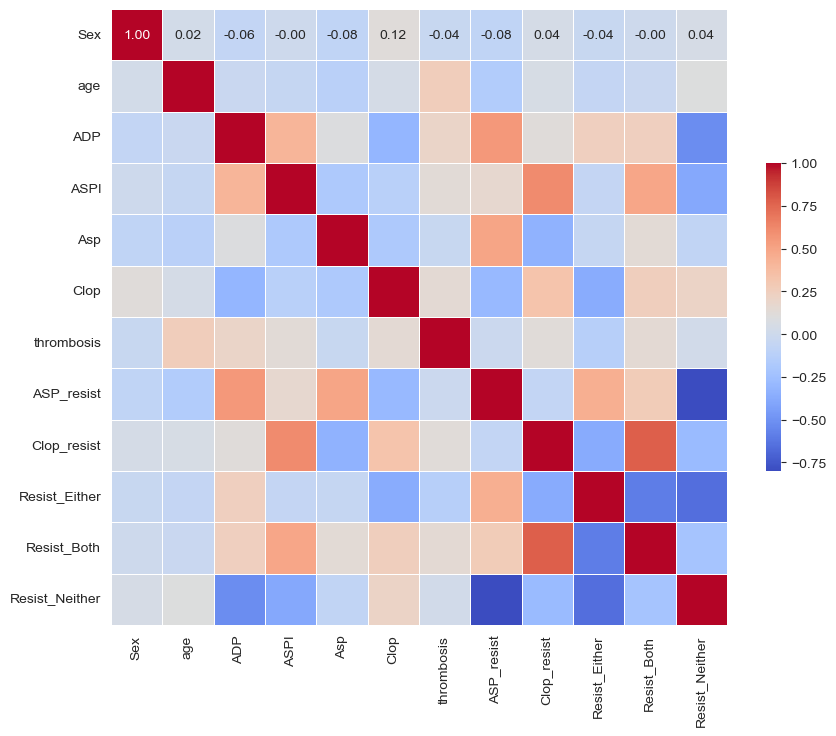

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


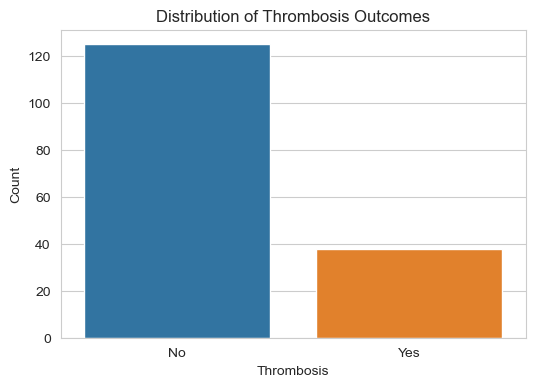

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of thrombosis outcomes
plt.figure(figsize=(6, 4))
sns.countplot(x='thrombosis', data=data)
plt.title('Distribution of Thrombosis Outcomes')
plt.xlabel('Thrombosis')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])  # Assuming thrombosis is encoded as 0s and 1s
plt.show()


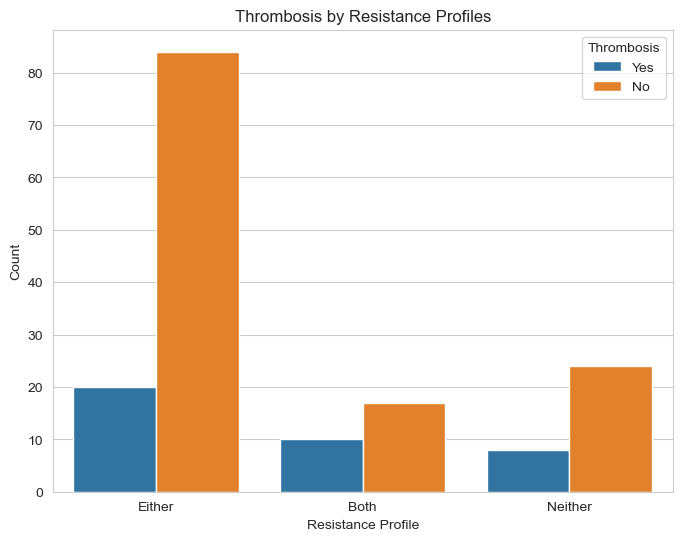

In [13]:
# Ensure 'Resistance_Profile' is correctly generated as a string
data['Resistance_Profile'] = data.apply(lambda x: 'Either' if x['Resist_Either'] == 1 
                                        else ('Both' if x['Resist_Both'] == 1 
                                              else 'Neither'), axis=1).astype(str)

# Ensure 'thrombosis' is treated as a categorical variable for plotting
# If 'thrombosis' is numerical (0, 1), convert it to string labels for clarity in plotting
data['thrombosis_label'] = data['thrombosis'].map({0: 'No', 1: 'Yes'}).astype(str)

plt.figure(figsize=(8, 6))
sns.countplot(x='Resistance_Profile', hue='thrombosis_label', data=data)
plt.title('Thrombosis by Resistance Profiles')
plt.xlabel('Resistance Profile')
plt.ylabel('Count')
# Here, 'hue' uses 'thrombosis_label' which is explicitly string-typed, should avoid the error
plt.legend(title='Thrombosis')
plt.show()


In [14]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(data['Resistance_Profile'], data['thrombosis'])
print(contingency_table)

# Perform the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test statistic: {chi2}")
print(f"P-value: {p}")


thrombosis           0   1
Resistance_Profile        
Both                17  10
Either              84  20
Neither             24   8
Chi-square test statistic: 3.8648768930874193
P-value: 0.14479469353732524


In [15]:
# Step 1: Assuming 'data' already has 'Resistance_Profile' and 'thrombosis' properly defined

# Step 2: Create a simplified contingency table focusing on 'Resist_Either' vs. thrombosis rates
# Note: 'Resist_Either' is directly available in the dataset as a column
contingency_table_either = pd.crosstab(data['Resist_Either'], data['thrombosis'])

print("Contingency Table for Resistance to Either Asp or Clop vs. Thrombosis:")
print(contingency_table_either)

# Step 3: Perform the Chi-square test
chi2_either, p_either, dof_either, expected_either = chi2_contingency(contingency_table_either)

print(f"\nChi-square test statistic: {chi2_either}")
print(f"P-value: {p_either}")


Contingency Table for Resistance to Either Asp or Clop vs. Thrombosis:
thrombosis      0   1
Resist_Either        
0              41  18
1              84  20

Chi-square test statistic: 2.0843947968846495
P-value: 0.14881118871819293


In [16]:
from scipy.stats import chi2_contingency

# First, make sure to define these columns in your dataset if not already defined
data['Resist_Asp_Only'] = ((data['ASP_resist'] == 1) & (data['Clop_resist'] == 0)).astype(int)
data['Resist_Clop_Only'] = ((data['ASP_resist'] == 0) & (data['Clop_resist'] == 1)).astype(int)
# 'Resist_Both' and 'Resist_Neither' should already be in your dataset based on previous steps

# Initialize a dictionary to store Chi-square results
chi_square_results = {}

# List of resistance profiles
resistance_profiles = ['Resist_Asp_Only', 'Resist_Clop_Only', 'Resist_Both', 'Resist_Neither']

for profile in resistance_profiles:
    # Create contingency table for each profile
    contingency_table = pd.crosstab(data[profile], data['thrombosis'])
    
    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Store the results
    chi_square_results[profile] = {'Chi2 Statistic': chi2, 'P-value': p}

# Display the results
for profile, results in chi_square_results.items():
    print(f"{profile} -> Chi2 Statistic: {results['Chi2 Statistic']:.4f}, P-value: {results['P-value']:.4f}")


Resist_Asp_Only -> Chi2 Statistic: 1.9202, P-value: 0.1658
Resist_Clop_Only -> Chi2 Statistic: 0.0000, P-value: 1.0000
Resist_Both -> Chi2 Statistic: 2.5513, P-value: 0.1102
Resist_Neither -> Chi2 Statistic: 0.0003, P-value: 0.9852


In [17]:
# Contingency Table for "Resist_Either"
contingency_either = pd.crosstab(data['Resist_Either'], data['thrombosis'])

# Contingency Table for "Resist_Both"
contingency_both = pd.crosstab(data['Resist_Both'], data['thrombosis'])

# Contingency Table for "Resist_Neither"
contingency_neither = pd.crosstab(data['Resist_Neither'], data['thrombosis'])


In [18]:
from scipy.stats import chi2_contingency

# Perform Chi-square test for "Resist_Either"
chi2_either, p_either, _, _ = chi2_contingency(contingency_either)
print(f"'Resist_Either' Chi-square Test: Chi2 = {chi2_either}, p-value = {p_either}")

# Perform Chi-square test for "Resist_Both"
chi2_both, p_both, _, _ = chi2_contingency(contingency_both)
print(f"'Resist_Both' Chi-square Test: Chi2 = {chi2_both}, p-value = {p_both}")

# Perform Chi-square test for "Resist_Neither"
chi2_neither, p_neither, _, _ = chi2_contingency(contingency_neither)
print(f"'Resist_Neither' Chi-square Test: Chi2 = {chi2_neither}, p-value = {p_neither}")


'Resist_Either' Chi-square Test: Chi2 = 2.0843947968846495, p-value = 0.14881118871819293
'Resist_Both' Chi-square Test: Chi2 = 2.5513139978213513, p-value = 0.11020256765226948
'Resist_Neither' Chi-square Test: Chi2 = 0.0003458592808356846, p-value = 0.985162362896305


In [19]:
from scipy.stats import fisher_exact

# Example using Fisher's Exact Test for a specific resistance profile
# Creating a contingency table for "Resist_Asp_Only" as an example
contingency_table_asp_only = pd.crosstab(data['Resist_Asp_Only'], data['thrombosis'])

# Perform Fisher's Exact Test
odds_ratio, p_value = fisher_exact(contingency_table_asp_only)
print(f"Odds Ratio: {odds_ratio}, P-value: {p_value}")


Odds Ratio: 0.5579150579150579, P-value: 0.13710127181377027


Logistic regression

In [20]:
import statsmodels.api as sm

# Prepare your independent variables (X) and dependent variable (y)
X = data[['Resist_Asp_Only', 'Resist_Clop_Only', 'Resist_Both', 'Resist_Neither']]  # Plus any other covariates of interest
y = data['thrombosis']

# Add a constant to the model (intercept)
X_const = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X_const).fit()

# Print the summary of the logistic regression model
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.531517
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:             thrombosis   No. Observations:                  163
Model:                          Logit   Df Residuals:                      159
Method:                           MLE   Df Model:                            3
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                 0.02120
Time:                        21:30:37   Log-Likelihood:                -86.637
converged:                       True   LL-Null:                       -88.514
Covariance Type:            nonrobust   LLR p-value:                    0.2894
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.8608   1.56e+07   -5.5e-08      1.000   -3.07e+07    3.07e+07
Resist_Asp

In [21]:
from scipy.stats import mannwhitneyu

# Example comparing age distributions between two groups
group1_ages = data[data['thrombosis'] == 0]['age']
group2_ages = data[data['thrombosis'] == 1]['age']

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(group1_ages, group2_ages)
print(f"Statistic: {stat}, P-value: {p_value}")


Statistic: 1590.0, P-value: 0.002063475803623161
